<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hot Hand "Fallacy" - A Bayesian Approach**
---



# **1. Introduction**

The hot hand fallacy is the belief that a person experiencing a successful outcome has a greater chance of success in subsequent attempts. In basketball, the hot hand fallacy is the belief that a player making consecutive shots in a row is speculated to have a non-trivial increase in their chance of making a shot.

Dataset is a log of shot attempts made by the top 15 NBA players in the 2014-15 season who made the most "hot-hand shots".

Our project defines "hot-hand shot" as any shot made by a player after the player has made their last 3 consecutive shots.

# **2. Data Cleaning**

Our data file is comprised of data from two datasets:

https://www.kaggle.com/datasets/dansbecker/nba-shot-logs

https://www.kaggle.com/datasets/justinas/nba-players-data

We took this data and added custom variables calculated by iterating over the data set.


In [ ]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit

df = pd.read_csv('/content/hhs_filter.csv')

In [ ]:
#### HELPER FUNCTIONS

def clean_data(df):
    """
    getting rid of unnecessary variables, replacing
    character values with integers,
    nothing too important for presentation purposes
    """
    # need to remove some variables we dont need for the analysis, we helpful
    # when creating the dataset
    df2 = df.iloc[:, 1:]

    df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                            "player_id", "GAME_SHOTS_TAKEN",
                            "SHOT_RESULT", "REFORMATED_DEF_NAME",
                            "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN"])

    #remove any rows that have some kind of error we have flagged that
    # cannot be find with generative modeling
    df3 = df3[df3.EXCLUDE == 0]

    #no longer need exclude and fgm column
    clean = df3.drop(columns= ["EXCLUDE"])

    # replace 'A' with '0'
    clean['LOCATION'].replace('A', 0, inplace=True)
    # replace 'A' with '0'
    clean['LOCATION'].replace('H', 1, inplace=True)
    # when shot clock is NaN, we will replace shot clock with game clock value
    clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']
    return clean


def get_sample_indices(df, amount):
    """ given dataframe return sample indices with <amount> of hhs and non_hhs
    shots from each player"""

    ind_dict = {}
    i = -1
    for index, row in df.iterrows():
        # DO NOT USE THE INDEX VARIABLE ITS GARBAGE AND WRONG
        i += 1
        player = row['player_name']
        if player not in ind_dict:
            ind_dict[player] = {'hhs': [], 'not_hhs': []}
        if row['HOT_HAND_SHOT_STREAK3']:
            ind_dict[player]['hhs'].append(i)
        else:
            ind_dict[player]['not_hhs'].append(i)

    sample_inds = []
    for player in ind_dict:
        sample_inds.extend(random.sample(ind_dict[player]['hhs'], amount))
        sample_inds.extend(random.sample(ind_dict[player]['not_hhs'], amount))

    return sample_inds


def predictor_matrix(data: pd.DataFrame, col_names: list,
                     adjust_std=False) -> np.array:
    """
    given a dataframe  and list  containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if adjust_std == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    means = np.mean(predictors, axis=0, keepdims=True)
    deviations = np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    normd_predictors = (predictors - means) / deviations
    return np.insert(normd_predictors, 0, 1, axis=1)

In [ ]:
np.random.seed(23)

clean = clean_data(df)
N = 750
# N = 250  num of samples to make code run faster
# removes noise and focuses the inference and justification for smaller dataset

# ENSURE N % num_players == 0
num_players = 15
sample_amount = int(N / num_players)
samp = clean.iloc[get_sample_indices(clean, sample_amount)]
samp = samp.drop(columns=["player_name"])

# **3. Exploratory Data Analysis**

In [ ]:
# design matrix 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

#Look into colinearity, and exclude some with high colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                  feature       VIF
0                     FGM  1.000000
1                LOCATION  1.006259
2             SHOT_NUMBER  3.915445
3                  PERIOD  3.595490
4      GAME_CLOCK_DECIMAL  1.314704
5              SHOT_CLOCK  1.139414
6                DRIBBLES  1.447631
7               SHOT_DIST  1.441369
8      DEFENDER_HEIGHT_CM  3.381771
9      DEFENDER_WEIGHT_KG  3.414692
10         CLOSE_DEF_DIST  1.290979
11          PLAYER_HEIGHT  7.811008
12          PLAYER_WEIGHT  6.587754
13  HOT_HAND_SHOT_STREAK3  1.106749


In [ ]:
# design matrix 2, removed some predictors with high multicolinearity or were variables we felt were not nessesary

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1
P2


7

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X2)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
               'CLOSE_DEF_DIST', 'PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity, notice how all predictors look to have little multi-colinearity

                 feature       VIF
0                    FGM  1.000000
1               LOCATION  1.000406
2             SHOT_CLOCK  1.059787
3              SHOT_DIST  1.390179
4     DEFENDER_HEIGHT_CM  1.240219
5         CLOSE_DEF_DIST  1.278497
6          PLAYER_HEIGHT  1.248225
7  HOT_HAND_SHOT_STREAK3  1.019586


In [ ]:
y2 = np.zeros((2*N,1))
y2[:,0] = samp['FGM']

# **4. Prior Philosophy**

explain idea from paper

# **5. Exploring Different Models**


Only standardize variables after bad performance ? Why would anyone choose to standardize everything without even checking that its needed?

will explore numerous different models (small sample) in this section and attempt to show that these models were considered and evaluated (including assumptions)

in last subsection we compare them

## Model 1

In [ ]:
import pymc as pm; import numpy as np
#model 1 (uses design matrix 2), Basic multivariate bayesian regression model
#redefine col names just for naming ease
col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

with pm.Model(coords={"cluster": col_names}) as MLR:
    # Define a multivariate normal (MvNormal) distribution for the regression coefficients ('betas').
    # 'mu' specifies the mean of the distribution, set to a zero vector of size P2+1 to indicate no prior bias.
    # 'cov' specifies the covariance matrix, set to an identity matrix of size P2+1, assuming independence and identical variance.
    # 'shape' specifies the shape of the variable, here a vector of size P2+1, where P2 is presumably the number of predictors.
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov=np.eye(P2+1), shape=(P2+1,), dims = 'cluster')
    # Define a Bernoulli distribution for the dependent variable 'y'.
    # 'logit_p' specifies the logit of the probability of success, calculated as the dot product of predictors 'X2' and coefficients 'betas'.
    # 'observed' is set to 'y2', indicating that 'y' is an observed variable in the data.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)

# do more analysis / visualizations

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')

## Model 2

In [ ]:

import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2, multivariate bayesian heirarchial regression using a horshoe prior and LKJ factor
with pm.Model(coords={"cluster": col_names}) as MLR:
   # Define an LKJ Cholesky covariance matrix, a method for specifying a prior over covariance matrices in a way that
    # is computationally efficient and ensures positive definiteness. It's particularly useful for multivariate normal distributions.
    packed_L = pm.LKJCholeskyCov("packed_L", n= P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    # Implement the horseshoe prior for regularization, helping in identifying truly relevant predictors among potentially many covariates.
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape= 1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))

     # Define the multivariate normal distribution for regression coefficients ('betas'), with a mean vector of zeros
    # and the covariance matrix 'Sigma' determined above.
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= Sigma, shape=(P2+1,), dims = 'cluster')

    # Define the observed variable 'y', modeled as a Bernoulli distribution with the logit of the probability
    # determined by the dot product of the predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)

    #set up and perform sampling using the Metropolis-Hastings algorithm, a specific MCMC method.
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH,random_seed=1999)

    #for proj we can make note on how long it takes computationally to use chol
    #problem in mixing?
    #invalid value could be near 0 value in log

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_MH,compact=False, combined = False);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata_MH).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata_MH, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata_MH)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')


## Model 3

In [ ]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3, bayesian multivariate regression model with horseshoe prior
with pm.Model(coords={"cluster": col_names}) as MLR:

    # Set up the horseshoe prior for regularization, aiming to identify significant predictors.
    # The horseshoe prior is a robust regularization method that can effectively handle cases with many predictors,
    # distinguishing between relevant and irrelevant ones by shrinking the latter towards zero.
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= np.eye(P2+1), shape=(P2+1,), dims = 'cluster')

     # Define the likelihood of the observed data 'y', assuming a Bernoulli distribution.
    # The logit of the success probability is given by the dot product of predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)

    #misspecified horshoe bc not shrinking to 0
    #regularized horseshoe, seeing something interestin with bi-modal, report on

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata,compact=False, combined = False);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')

## Model 4

In [ ]:
#model 4, multivariate bayesian regression with standard normal prior on all predictors other than hot-hand, hot hand has a spike slab with standard normal prior
P2 = X2.shape[1]

col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT']
with pm.Model(coords={"cluster": col_names}) as MLR:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)

    # Coefficients for other predictors
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,), dims = 'cluster')
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2-1,)), cov= np.eye(P2-1), shape=(P2-1,), dims = 'cluster')

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with MLR:
    idata = pm.sample(random_seed=1999)


In [ ]:
import arviz as az; import matplotlib.pyplot as plt;

print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

import arviz as az
import matplotlib.pyplot as plt

# Assuming idata is the InferenceData object from sampling the model

# Plot trace plots for model parameters to assess convergence
az.plot_trace(idata,compact=False, combined = False);
plt.show()

# Print summary statistics for the posterior distributions
# This will provide you with mean, sd, hdi intervals, etc.
summary_stats = az.summary(idata)
print(summary_stats)

# Plot autocorrelation for each parameter
# This helps to check if the Markov chain has mixed well
az.plot_autocorr(idata)
plt.show()

# Plot energy to check for sampling pathology
az.plot_energy(idata)
plt.show()

# Check effective sample sizes (ess)
# Good ess values suggest that the posterior distribution has been well explored
ess = az.ess(idata)
print("Effective Sample Sizes:\n", ess)

# Check for divergences
# Divergences can indicate problems with the sampling
divergences = az.plot_pair(idata, kind='scatter', divergences=True)
plt.title("Divergence Check")
plt.show()

# Calculate R-hat diagnostics
# Values close to 1.0 suggest that the chain has converged
rhat = az.rhat(idata)
print("R-hat Diagnostics:\n", rhat)

# Optionally, visualize the posterior distributions of parameters
# This gives you a sense of the parameter uncertainty
az.plot_posterior(idata)
plt.show()


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')

## Model 5

In [ ]:
#model 5
P2 = X2.shape[1]
col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT']

# wanted to time code
# start = time.time()

with pm.Model(coords={"cluster": col_names}) as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)


    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.75;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=P2-1)

    # Coefficients for other predictors, using horsehoe
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2-1,)), cov= np.eye(P2-1), shape=(P2-1,), dims = 'cluster')

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other*weights, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with model:
    idata = pm.sample(random_seed=1999)
    predictive = pm.sample_posterior_predictive(idata)

Text(0.5, 1.0, 'Posterior Predictive plot')

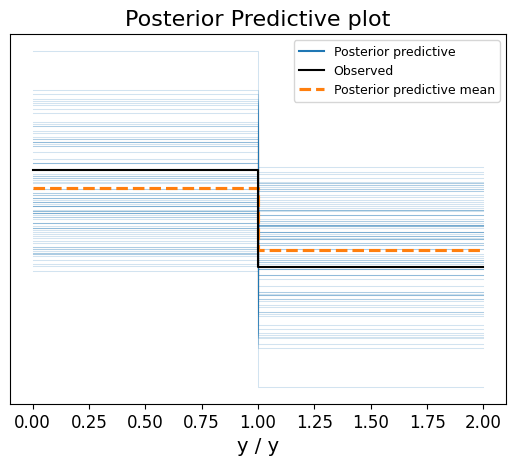

In [ ]:
# Plotting predicted vs. actual outcomes
# mean_preds = np.mean(posterior_preds, axis=0)
# plt.scatter(mean_preds, y2.flatten(), alpha=0.1)
# plt.xlabel('Predicted Probability')
# plt.ylabel('Actual Outcome')
# plt.title('Predicted vs. Actual Outcomes')
# plt.show()
az.plot_ppc(predictive, num_pp_samples=100)
plt.title('Posterior Predictive plot')

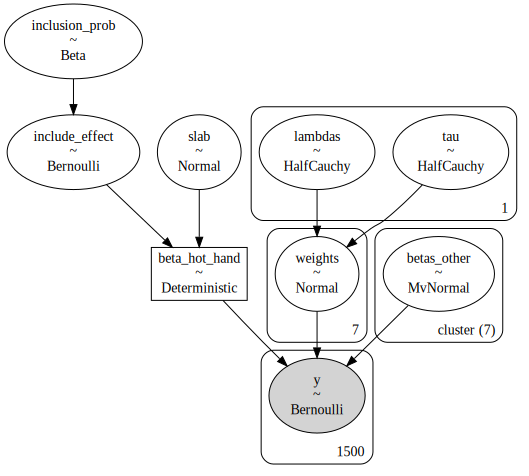

In [ ]:
# Visualization of model graph
pm.model_to_graphviz(model)

HMC Split-Rhats {'slab': 1.002825895, 'include_effect': 0.999983139, 'weights': array([1.01944902, 1.00164811, 1.02240504, 1.02988833, 1.02419466,
       1.02748283, 1.04146498]), 'betas_other': array([1.0121581 , 1.00225689, 1.01007462, 1.0222601 , 1.01259595,
       1.01661172, 1.01382743]), 'inclusion_prob': 1.005999912, 'tau': array([1.00719046]), 'lambdas': array([1.00426092]), 'beta_hot_hand': 1.004123445} | 

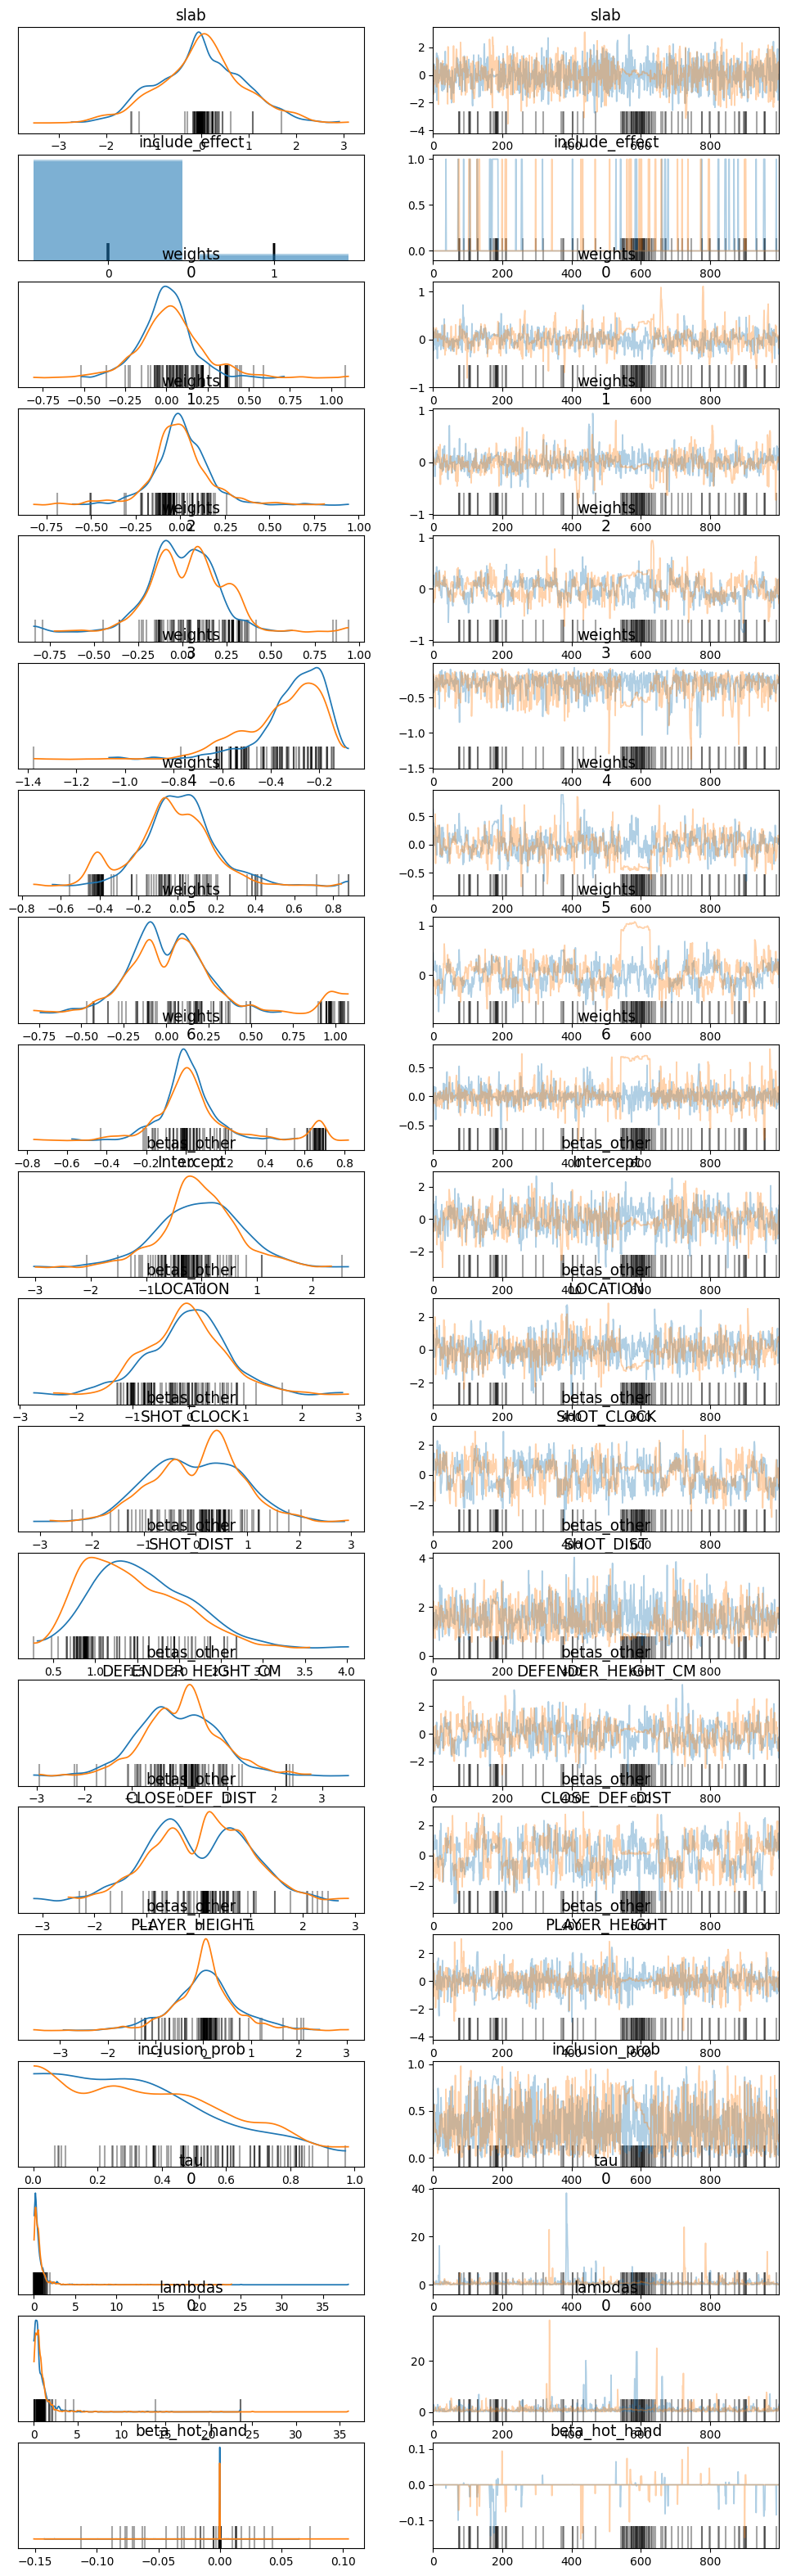

                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
slab                            -0.007  0.934  -1.689    1.859      0.022   
include_effect                   0.056  0.230   0.000    0.000      0.011   
weights[0]                       0.014  0.186  -0.326    0.386      0.014   
weights[1]                      -0.000  0.173  -0.313    0.359      0.008   
weights[2]                       0.016  0.201  -0.320    0.366      0.020   
weights[3]                      -0.328  0.156  -0.627   -0.123      0.017   
weights[4]                      -0.009  0.206  -0.451    0.334      0.021   
weights[5]                       0.043  0.293  -0.562    0.525      0.043   
weights[6]                       0.036  0.203  -0.436    0.472      0.033   
betas_other[Intercept]          -0.038  0.739  -1.484    1.402      0.032   
betas_other[LOCATION]           -0.035  0.717  -1.544    1.170      0.041   
betas_other[SHOT_CLOCK]          0.020  0.867  -1.582    1.540      0.059   

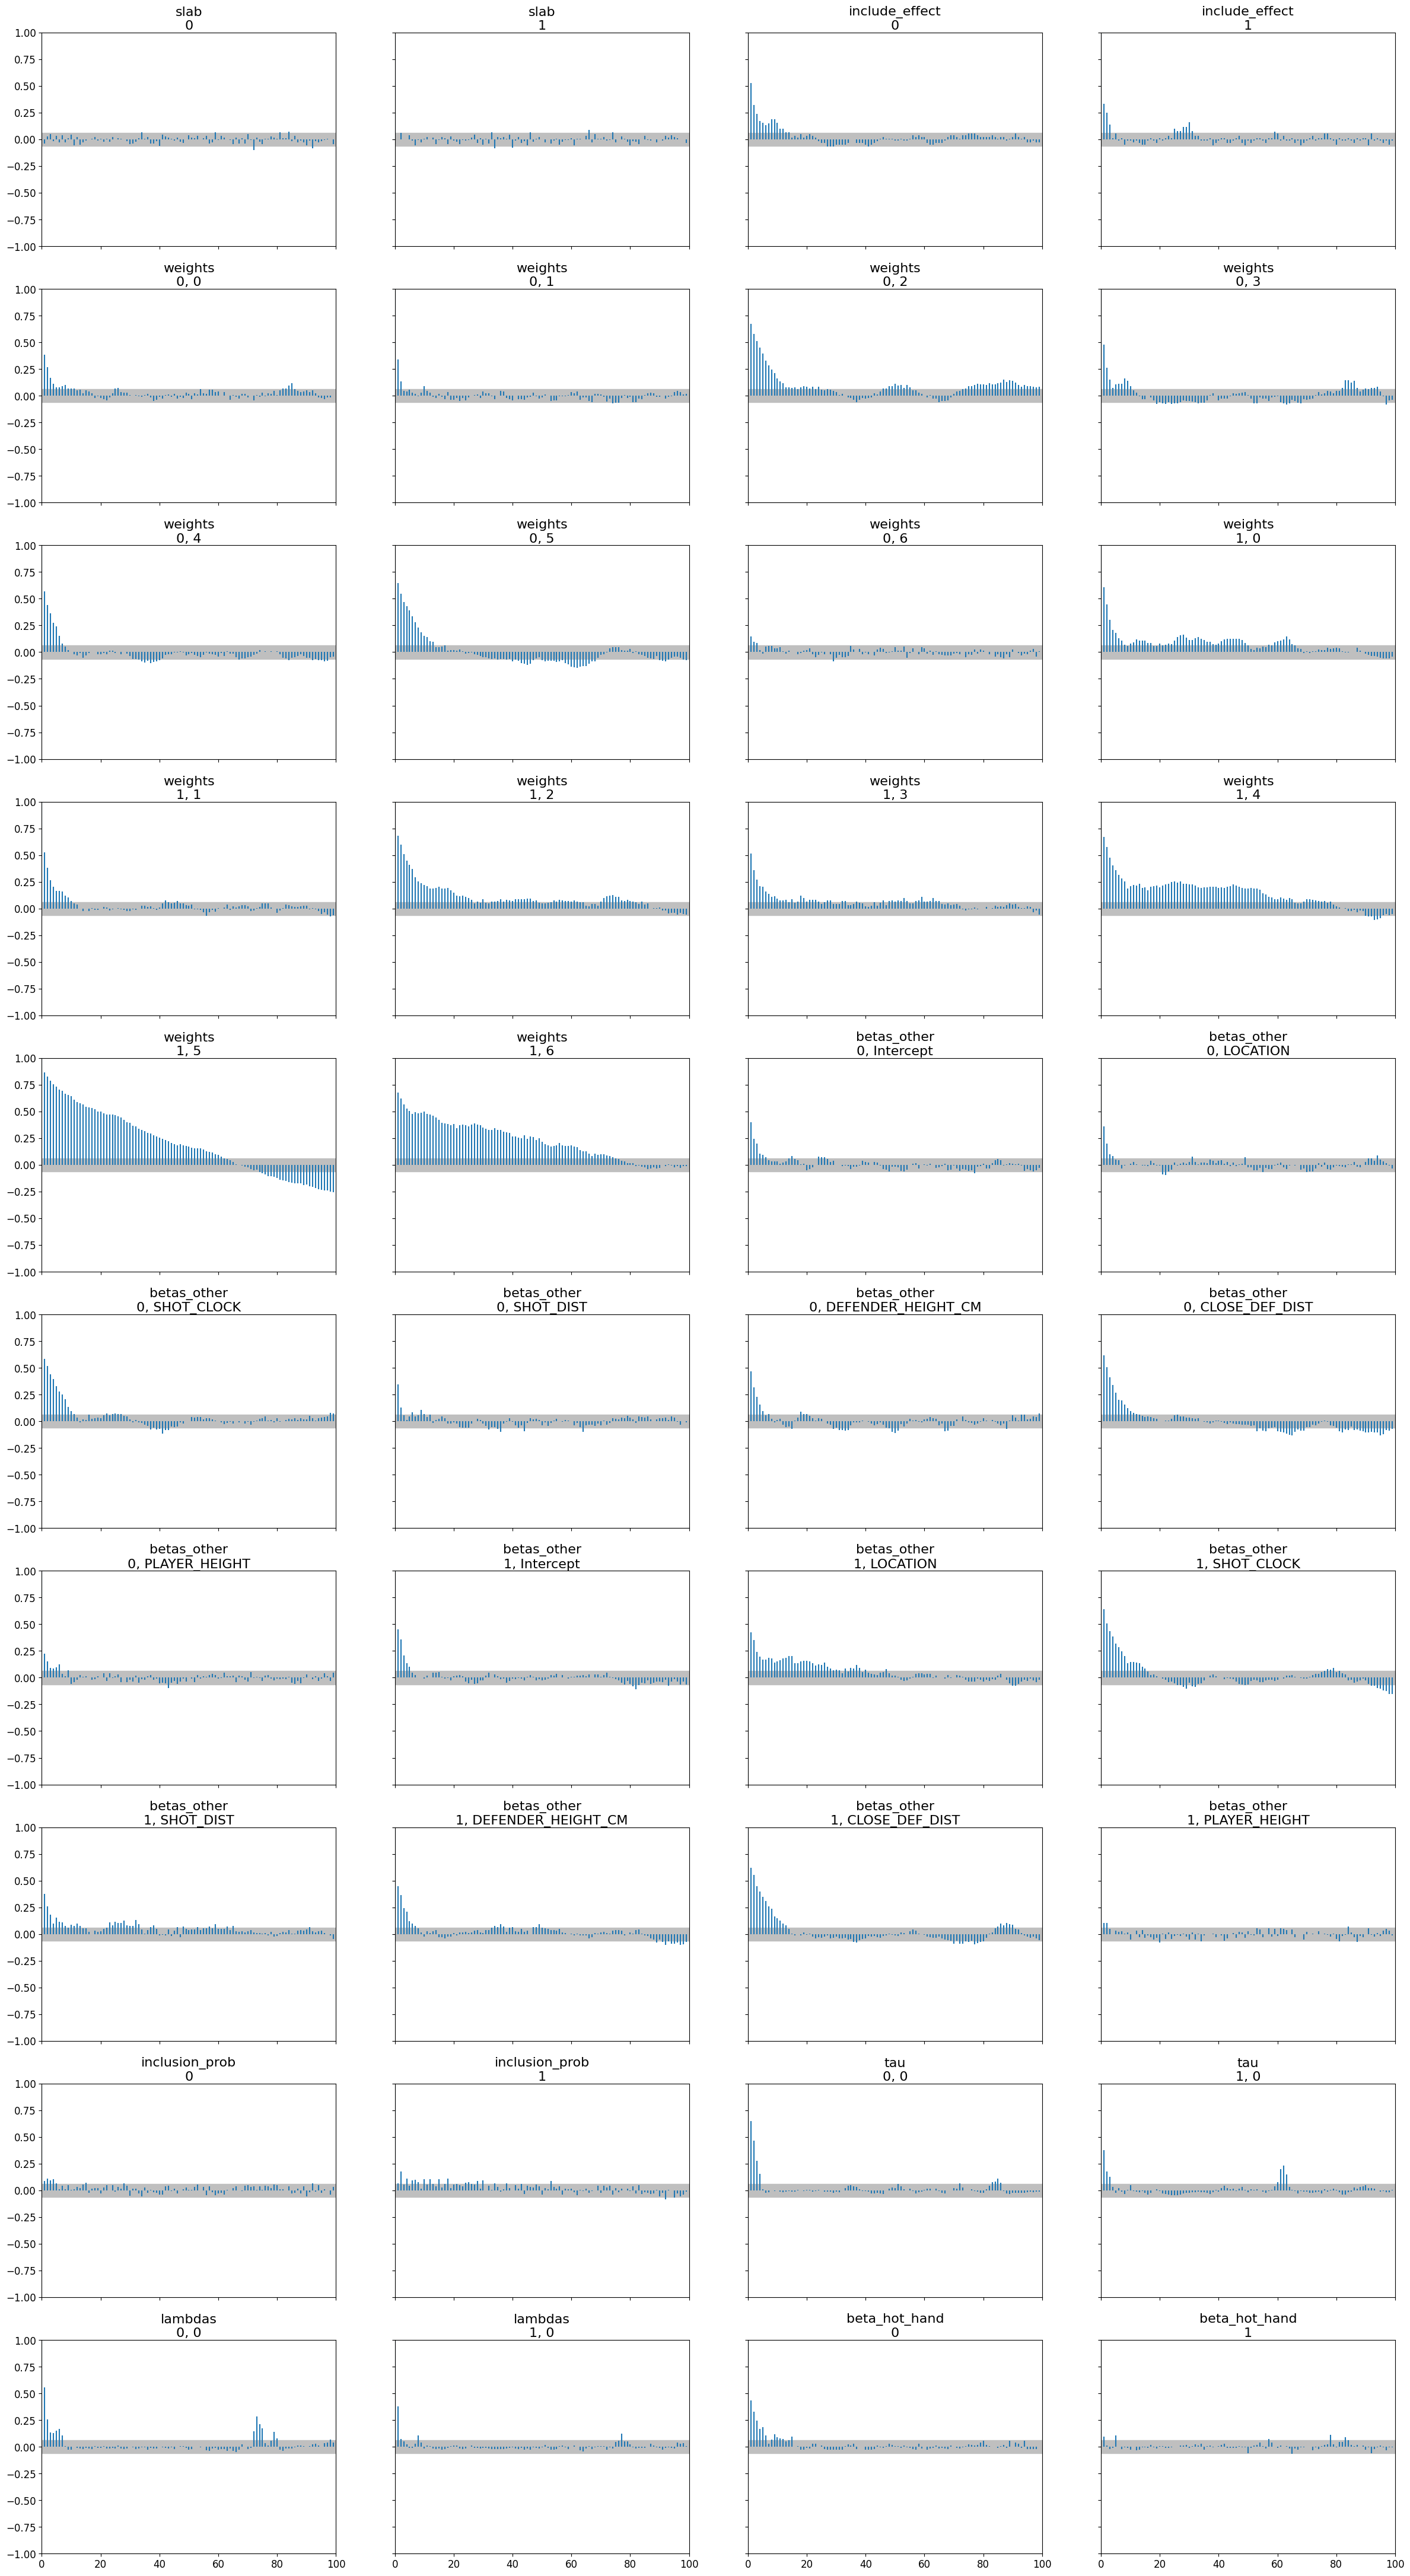

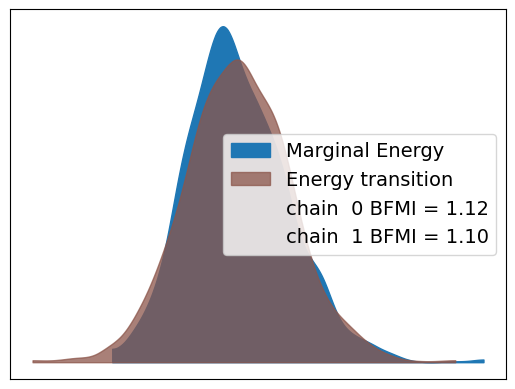

Effective Sample Sizes:
 <xarray.Dataset>
Dimensions:         (weights_dim_0: 7, cluster: 7, tau_dim_0: 1,
                     lambdas_dim_0: 1)
Coordinates:
  * weights_dim_0   (weights_dim_0) int64 0 1 2 3 4 5 6
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
  * tau_dim_0       (tau_dim_0) int64 0
  * lambdas_dim_0   (lambdas_dim_0) int64 0
Data variables:
    slab            float64 1.731e+03
    include_effect  float64 463.3
    weights         (weights_dim_0) float64 189.9 461.9 107.0 ... 97.87 105.3
    betas_other     (cluster) float64 512.1 295.0 228.3 230.6 472.5 256.9 901.9
    inclusion_prob  float64 601.2
    tau             (tau_dim_0) float64 708.1
    lambdas         (lambdas_dim_0) float64 776.9
    beta_hot_hand   float64 880.0


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


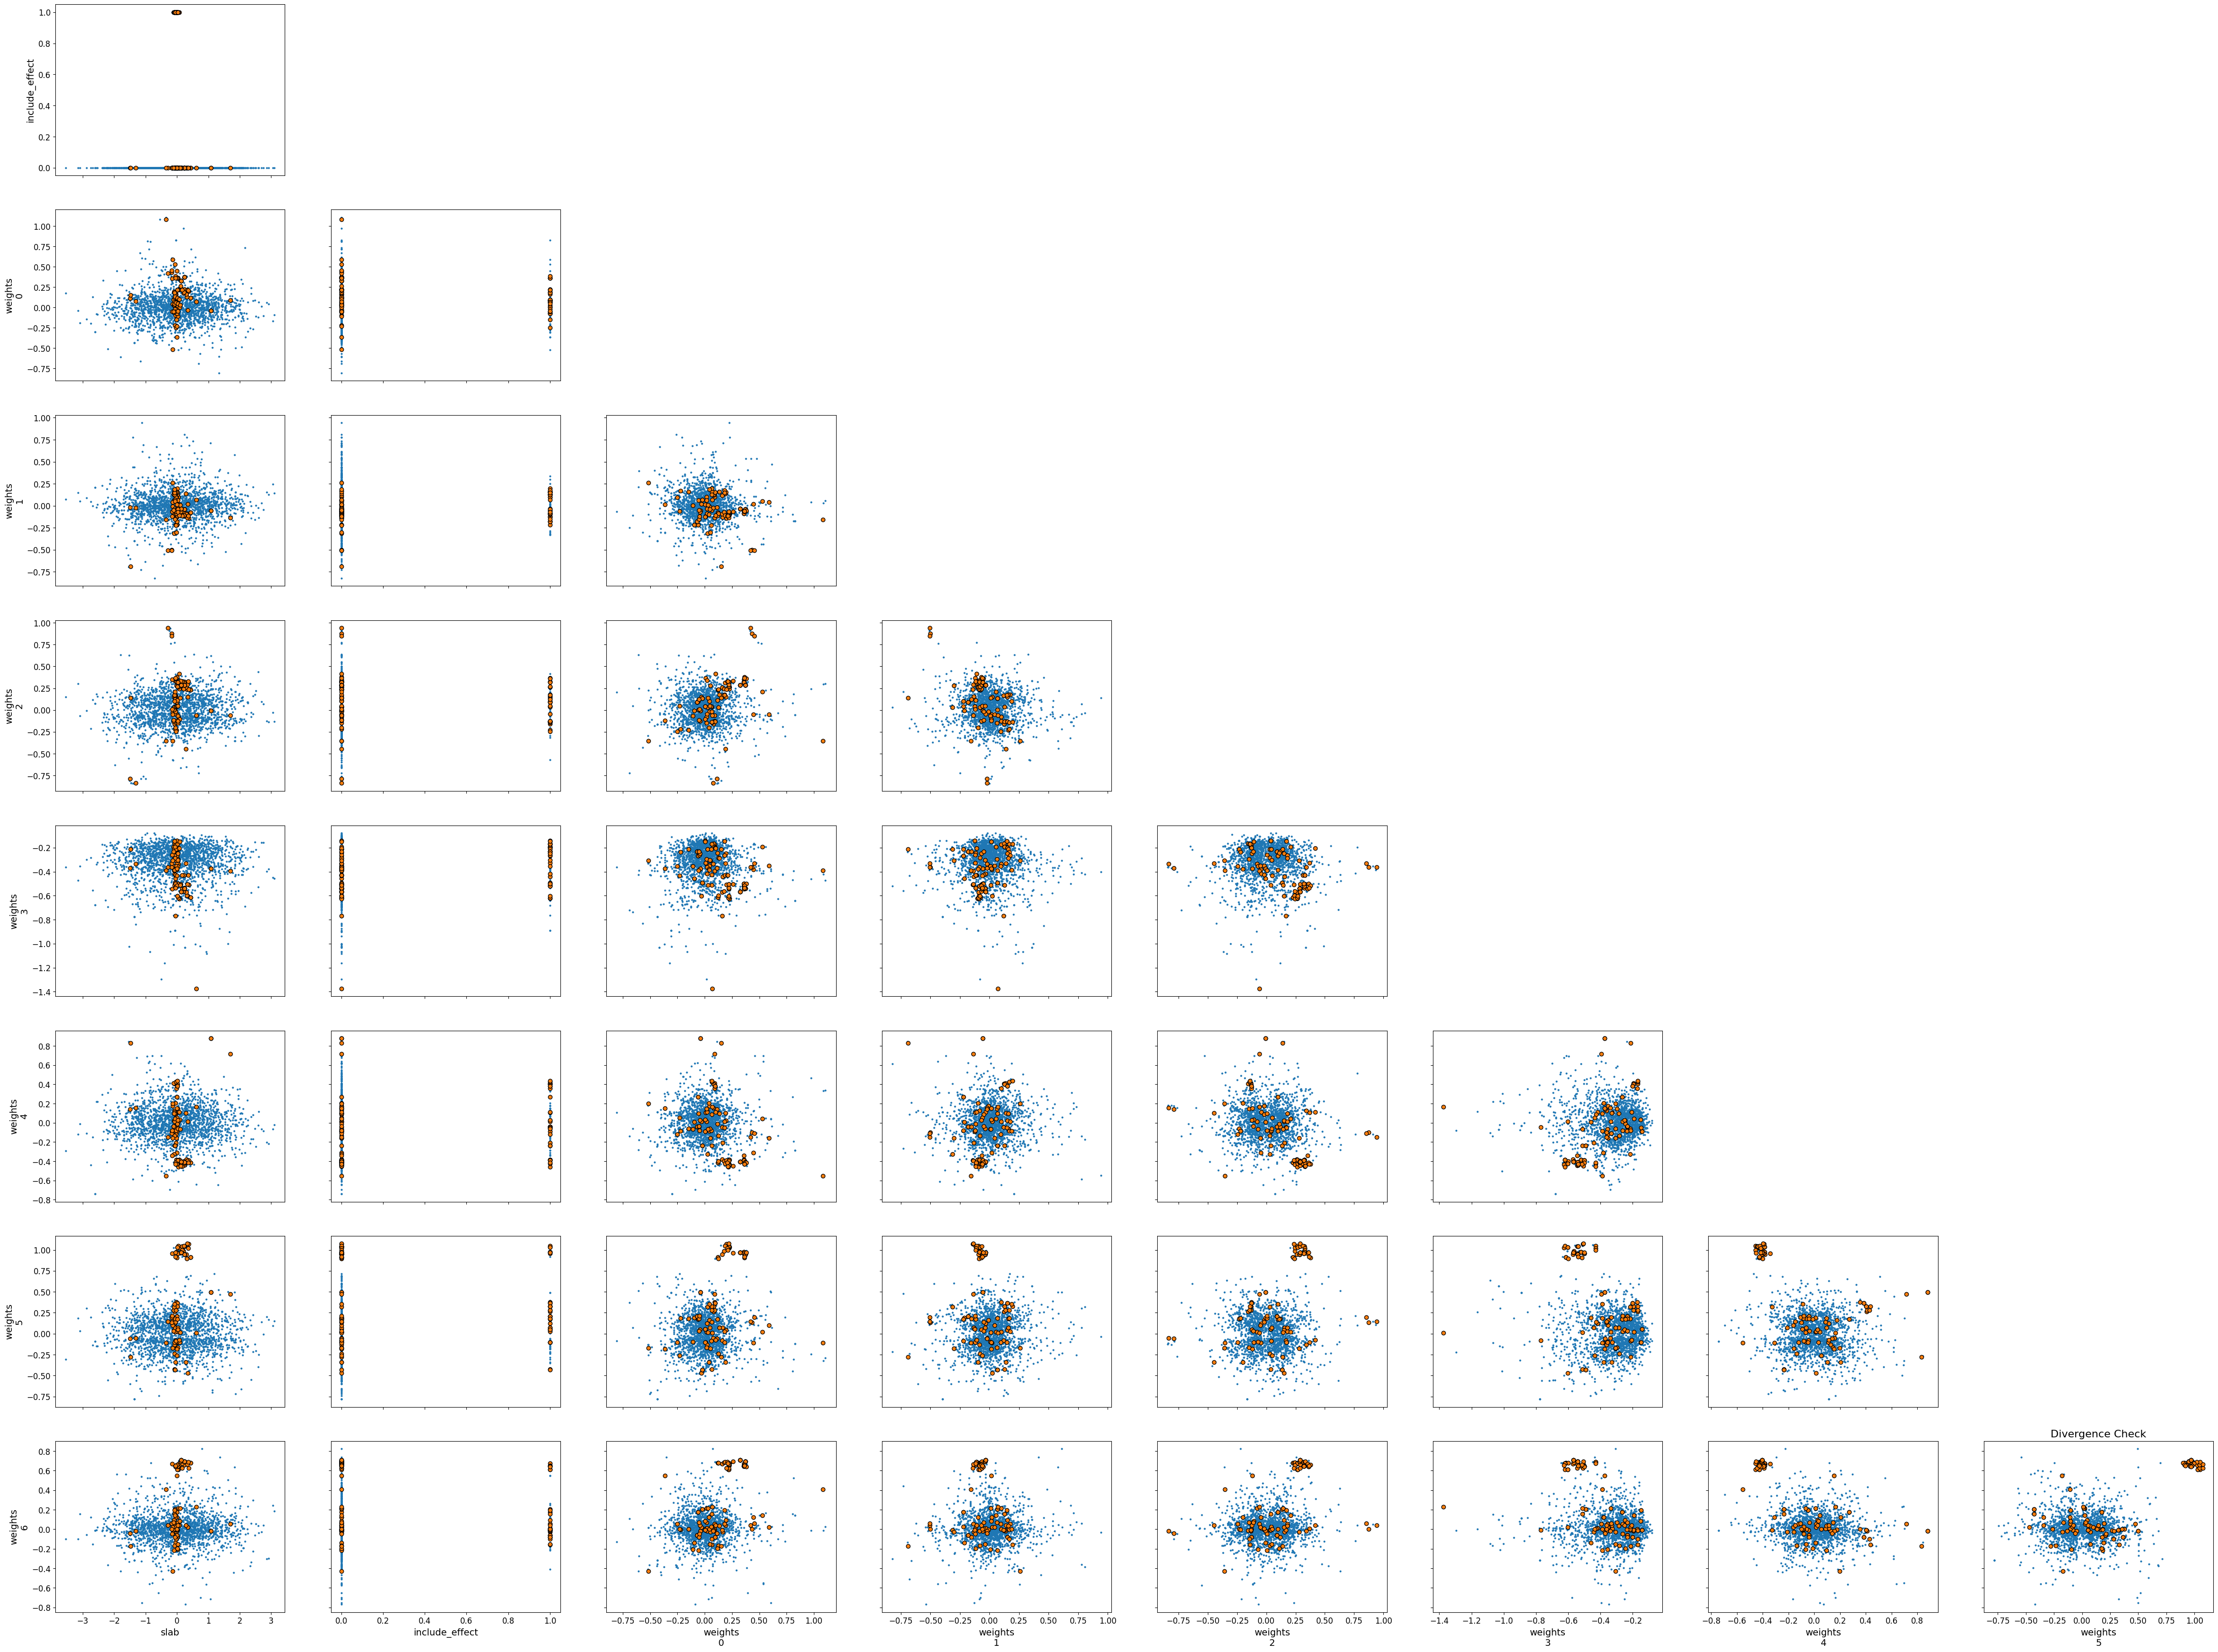

R-hat Diagnostics:
 <xarray.Dataset>
Dimensions:         (weights_dim_0: 7, cluster: 7, tau_dim_0: 1,
                     lambdas_dim_0: 1)
Coordinates:
  * weights_dim_0   (weights_dim_0) int64 0 1 2 3 4 5 6
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
  * tau_dim_0       (tau_dim_0) int64 0
  * lambdas_dim_0   (lambdas_dim_0) int64 0
Data variables:
    slab            float64 1.003
    include_effect  float64 1.0
    weights         (weights_dim_0) float64 1.019 1.002 1.022 ... 1.027 1.041
    betas_other     (cluster) float64 1.012 1.002 1.01 1.022 1.013 1.017 1.014
    inclusion_prob  float64 1.006
    tau             (tau_dim_0) float64 1.007
    lambdas         (lambdas_dim_0) float64 1.004
    beta_hot_hand   float64 1.004


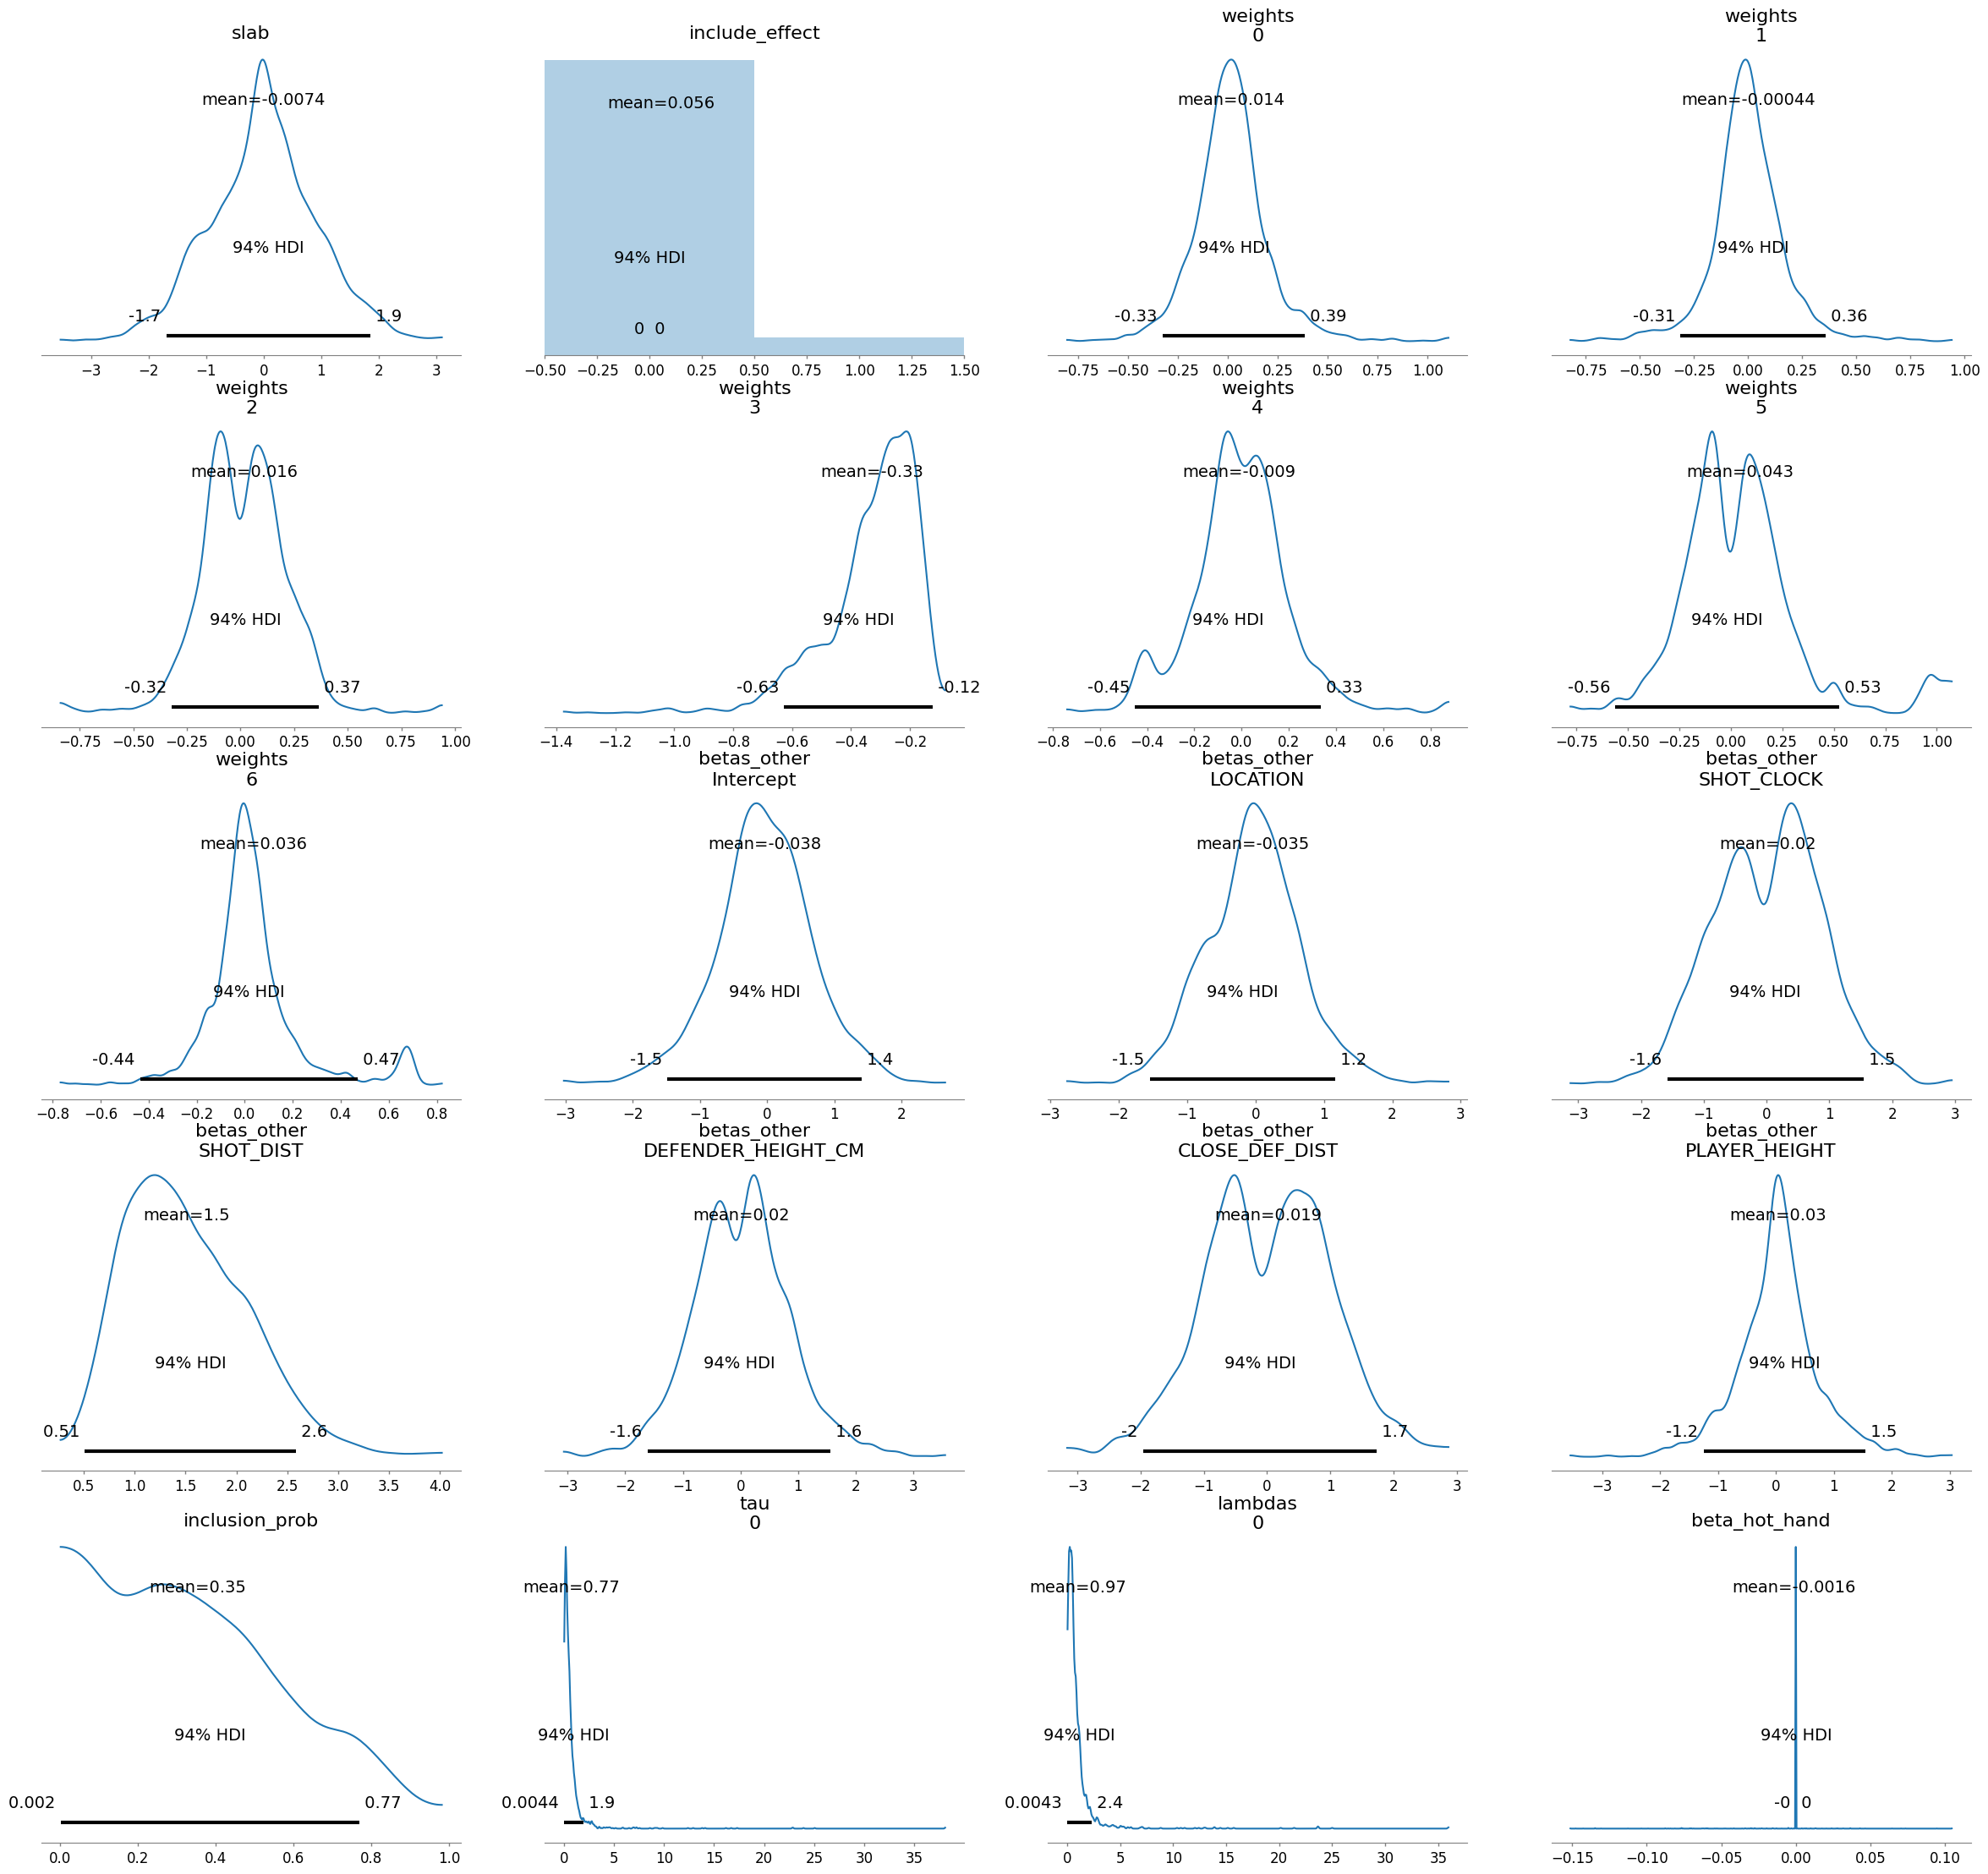

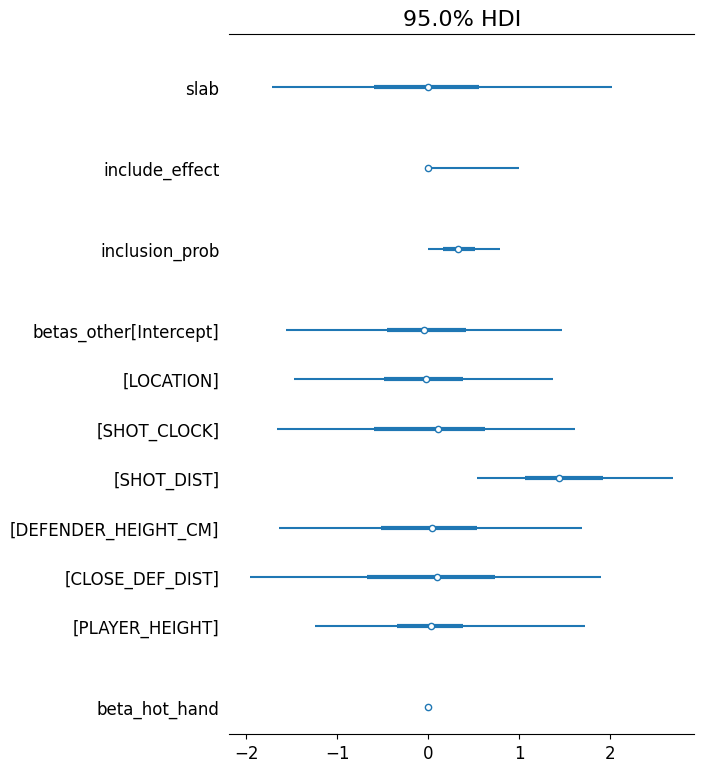

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;

print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

import arviz as az
import matplotlib.pyplot as plt

# Assuming idata is the InferenceData object from sampling the model

# Plot trace plots for model parameters to assess convergence
az.plot_trace(idata,compact=False, combined = False);
plt.show()

# Print summary statistics for the posterior distributions
# This will provide you with mean, sd, hdi intervals, etc.
summary_stats = az.summary(idata)
print(summary_stats)

# Plot autocorrelation for each parameter
# This helps to check if the Markov chain has mixed well
az.plot_autocorr(idata)
plt.show()

# Plot energy to check for sampling pathology
az.plot_energy(idata)
plt.show()

# Check effective sample sizes (ess)
# Good ess values suggest that the posterior distribution has been well explored
ess = az.ess(idata)
print("Effective Sample Sizes:\n", ess)

# Check for divergences
# Divergences can indicate problems with the sampling
divergences = az.plot_pair(idata, kind='scatter', divergences=True)
plt.title("Divergence Check")
plt.show()

# Calculate R-hat diagnostics
# Values close to 1.0 suggest that the chain has converged
rhat = az.rhat(idata)
print("R-hat Diagnostics:\n", rhat)

# Optionally, visualize the posterior distributions of parameters
# This gives you a sense of the parameter uncertainty
az.plot_posterior(idata)
plt.show()

# Forest plots
az.plot_forest(idata, var_names=['slab', 'include_effect', 'inclusion_prob', 'betas_other', 'beta_hot_hand'], combined=True, hdi_prob=0.95)
plt.show()

## Model 6
but i doubt we keep this because removing the only helpful predictor we have is prob not a good idea

In [ ]:
# # design matrix 3, removed shot dist bc it appears to be overpowering the other factors

# col_names3 = ['LOCATION', 'SHOT_CLOCK', 'DEFENDER_HEIGHT_CM',
#               'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
# X3 = predictor_matrix(samp, col_names3)
# P3 = X3.shape[1] - 1



In [ ]:
# #model 6, removed shot_dist

# P3 = X3.shape[1]
# col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'DEFENDER_HEIGHT_CM',
#               'CLOSE_DEF_DIST','PLAYER_HEIGHT']

# with pm.Model(coords={"cluster": col_names}) as model:
#     # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
#     inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
#     slab = pm.Normal('slab', mu=0, sigma=1)

#     # Binary variable to choose between spike (effect = 0) and slab
#     include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

#     # Coefficient for HOT_HAND_SHOT_STREAK3
#     # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
#     beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)


#     #Horsehoe prior to help distinguish useful predictors
#     tau_0 = 0.75;
#     tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
#     lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
#     weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=P3-1)

#     # Coefficients for other predictors, using horsehoe
#     #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))
#     betas_other = pm.MvNormal('betas_other', mu= np.zeros((P3-1,)), cov= np.eye(P3-1), shape=(P3-1,), dims = 'cluster')

#     # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
#     # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
#     betas = pm.math.concatenate([betas_other*weights, [beta_hot_hand]])

#     # Calculate the probability of a shot being made
#     p_shot_made = pm.math.sigmoid(pm.math.dot(X3, betas))

#     # Likelihood of observing the data
#     y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
# with model:
#     idata = pm.sample(random_seed=1999)

In [ ]:
# import arviz as az
# import matplotlib.pyplot as plt
# import numpy as np

# # Customizing plot parameters for better readability
# plt.rcParams.update({
#     'font.size': 14,
#     'axes.labelsize': 14,
#     'axes.titlesize': 16,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
# })

# # Increase the figure size
# # Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# # If the resulting plot still appears squished, consider making the figure size even larger,
# # or reducing the number of variables plotted in a single call to plot_trace
# az.plot_trace(idata, compact=False, combined=False, figsize=(25, P3*2))  # P2 is the number of parameters

# # The layout will be adjusted automatically since we are not using 'ax' anymore
# plt.show()

# # Print the R-hat statistics
# rhat_values = az.rhat(idata)
# print("HMC Split-Rhats", {k: np.round(v.values, P3+1) for k, v in rhat_values.items()}, end=' | ')

In [ ]:
# # Posterior plots
# az.plot_posterior(idata, var_names=['slab', 'include_effect', 'inclusion_prob','betas_other', 'beta_hot_hand'])
# plt.show()

# # Forest plots
# az.plot_forest(idata, var_names=['slab', 'include_effect', 'inclusion_prob', 'betas_other', 'beta_hot_hand'], combined=True, hdi_prob=0.95)
# plt.show()

## Choosing a Model

compare performance of models to justify choosing 5 as our “best” one (can use smaller samples to pick the best model then run it again on a big sample)

# **6. The Final Model**

obv this has to be the model we presented yesterday.
maybe come up with a better title;
rerun model with big 750 sample. check assumptions and look at results and all that... leave the conclusion for these results for the next section

# **7. Conclusion**

our verdict on the "fallacy" and interpreting the results from previous section

# **8. Limitations**

We provide a list of limitations and further considerations for our model.

Dependence of outcomes:
We attempted to account for the sequential dependence in the outcomes by adding an indicator variable for streaks of shots made. However, this may not fully account for dependence between outcome. This means that it may not be appropriate to use a generalized linear model. A more appropriate model is a two state Hidden Markov Model.

Definition of a "hot hand":
Our current definition of a "hot hand" is making three consecutive shots in a row. Other definitions of a "hot hand" could be considered e.g. a quarter where the player's fg% is significantly higher than usual.

Consider other predictors:
Some examples of predictors we could consider are field goal% of the season, different types of field goals, opponent defensive rating, and team defensive rating.

Subset of playerbase:
This model investigated the impact of the "hot hand" on star players. A further investigation could investigate the impact of the "hot hand" on average NBA players.
